In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit
import h5py
import pyvisa
import time
from scipy.signal import savgol_filter
import scipy.signal as signal
from scipy import interpolate
from scipy.signal import windows
from matplotlib.ticker import MaxNLocator
from scipy.optimize import least_squares
import datetime

In [2]:
factor = 2
SMALL_SIZE = factor*8
MEDIUM_SIZE = factor*10
BIGGER_SIZE = factor*12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Plotting/data functions

In [3]:
def choose_time_unit(t):
    if t > 24*3600:
        return "days", 24*3600
    elif t > 3600:
        return "h", 3600
    elif t > 60:
        return "min", 60
    else:
        return "s", 1

In [4]:
def list_dsets(fname="test.hdf"):
    with h5py.File(fname, 'r') as f:
        return list(f.keys())

In [5]:
def plot(run_name, fname="test.hdf", i_arr=[0,-1]):
    # get data from file
    with h5py.File(fname, 'r') as f:
        dset = f[run_name+"/particulates_monitoring/SPS30"][i_arr[0]:i_arr[1]]

        # plot PM2.5 over time
        dset["time"] -= dset["time"][-1]
        t_unit, div = choose_time_unit(-dset["time"][0])
        fig, ax = plt.subplots()
        ax.plot(dset["time"]/div, dset["PM2.5"])
        
        # display average PM2.5
        avg_PM = np.mean(dset["PM2.5"])
        ax.set_title(f"$\langle\mathrm{{PM2.5}}\\rangle={avg_PM:.2f}\;\mu$g/m$^3$")
        
    ax.set_xlabel(f"time [{t_unit}]")
    ax.set_ylabel("PM2.5 [$\mu$g/m$^3$]")
    ax.grid()

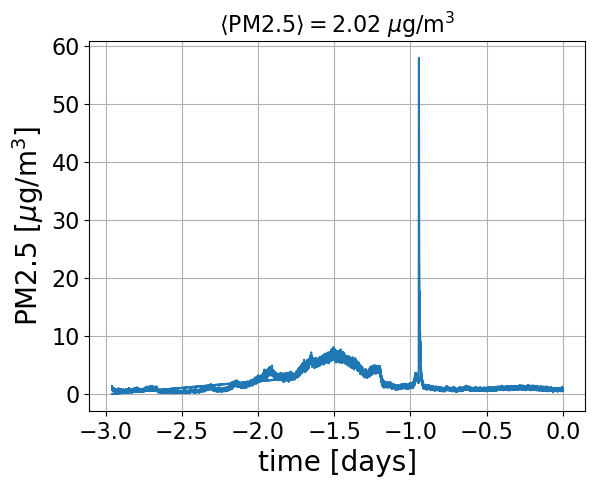

In [12]:
plot(list_dsets()[-1], i_arr=[0,-1])

### No HDF

In [4]:
rm = pyvisa.ResourceManager()
rm.list_resources()

('ASRL4::INSTR', 'ASRL14::INSTR')

In [ ]:
with rm.open_resource('ASRL14::INSTR') as SPS30:
    time.sleep(2)
    try:
        while True:
            with open('SPS30.log', 'a') as f:
                resp = SPS30.query('r').strip()
                print(time.ctime(time.time()), ':', resp, end='\r')
                f.write(str(int(time.time())) + "," + resp + '\n')
                time.sleep(1)
    except KeyboardInterrupt:
        pass

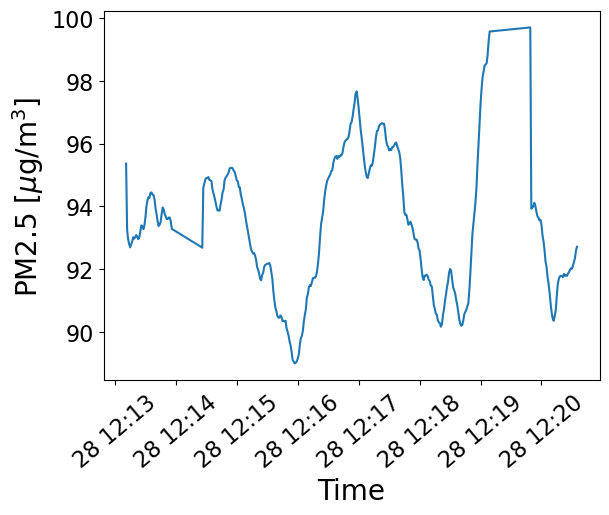

In [65]:
def plot_simple(fname):
    # get radiation data
    data = np.loadtxt(fname, delimiter=',')
    t = [datetime.datetime.fromtimestamp(x) for x in data[:,0]]
    
    plt.plot(t, data[:,2])
    
    plt.xticks(rotation=40)
    plt.xlabel("Time")
    plt.ylabel("PM2.5 [$\mu$g/m$^3$]")
    plt.grid()
    
plot_simple("SPS30.log")